# MLP
Training auf IDS17 80%  
Validierung auf IDS17 10%   
Test auf IDS17 10%  
Test auf IDS18 folgt in nächstem Skript

In [29]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [30]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='31_cnn.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnis der CSV-Dateien
ids17_prep_1 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet_prep_1/ids17.parquet'
ids18_prep_1 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet_prep_1/ids18.parquet'
hybrid_train_prep_1 =  '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_train.parquet'
hybrid_test_prep_1 = '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_test.parquet'

### Laden des Datensatzes

In [31]:
# Datensatz einlesen für Training 80%, Validierung 10% und Test 10%
df = pd.read_parquet(ids17_prep_1)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))
print(df.shape)
print(df.columns)

2024-11-20 11:04:43 - INFO - Class distribution
Label
BENIGN                          1582561
DoS Hulk                         158468
DDoS-LOIC-HTTP                    95144
Infiltration - NMAP Portscan      71767
DoS GoldenEye                      7567
DoS Slowloris                      3859
SSH-BruteForce                     2961
Botnet Ares                         736
Name: count, dtype: int64


(1923063, 52)
Index(['Fwd IAT Total', 'Dst Port', 'FIN Flag Count', 'Packet Length Variance',
       'Down/Up Ratio', 'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'URG Flag Count', 'Bwd Packets/s', 'Total TCP Flow Time',
       'Bwd Bulk Rate Avg', 'Total Length of Fwd Packet', 'Bwd IAT Mean',
       'Bwd Packet/Bulk Avg', 'Fwd IAT Max', 'Protocol', 'Flow IAT Min',
       'Bwd Header Length', 'Active Max', 'Total Fwd Packet',
       'Subflow Bwd Packets', 'Fwd Header Length', 'Fwd Seg Size Min',
       'Fwd RST Flags', 'Idle Std', 'Fwd Packet Length Min',
       'Bwd Init Win Bytes', 'Bwd Packet Length Std', 'RST Flag Count',
       'Fwd Act Data Pkts', 'Subflow Fwd Packets', 'ECE Flag Count',
       'SYN Flag Count', 'Bwd URG Flags', 'Average Packet Size', 'Bwd IAT Max',
       'Bwd PSH Flags', 'Total Length of Bwd Packet', 'Bwd RST Flags',
       'Flow Bytes/s', 'Fwd Bulk Rate Avg', 'Fwd IAT Min', 'Active Std',
       'Packet Length Max', 'Bwd IAT Total', 'Fwd IAT Mean',

### Trennen von Features und Labels

In [32]:
X = df.iloc[:, :-1]  # Alle Spalten außer der letzten
print("Form von X:", X.shape)
y = df.iloc[:, -1]   # Die letzte Spalte
print("Form von y:", y.shape)


Form von X: (1923063, 51)
Form von y: (1923063,)


### Label Encoding für y

In [33]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Einzigartige Labels:", label_encoder.classes_)
print("Kodierte Labels:", np.unique(y_encoded))

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce']
Kodierte Labels: [0 1 2 3 4 5 6 7]


### Aufteilen der Daten in Trainings-, Validierungs- und Testdatensätze

In [34]:
# Aufteilen in Trainings- und temporäre Datensätze
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.20, random_state=42, stratify=y_encoded)

# Aufteilen in Validierungs- und Testdaten
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Form von X_train:", X_train.shape)
print("Form von X_val:", X_val.shape)
print("Form von X_test:", X_test.shape)


Form von X_train: (1538450, 51)
Form von X_val: (192306, 51)
Form von X_test: (192307, 51)


### Skallierung von X

In [35]:
# Skalieren der Daten
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit auf Trainingsdaten
X_val_scaled = scaler.transform(X_val)         # Transform auf Val.-Daten
X_test_scaled = scaler.transform(X_test)       # Transform auf Testdaten

### Überprüfen der Klassenverteilung

In [36]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_train, "Trainingsdatensatz")
print_class_distribution(y_val, "Validierungsdatensatz")
print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Trainingsdatensatz:
  Klasse 0: 1266048 Beispiele (82.29%)
  Klasse 1: 589 Beispiele (0.04%)
  Klasse 2: 76115 Beispiele (4.95%)
  Klasse 3: 6054 Beispiele (0.39%)
  Klasse 4: 126774 Beispiele (8.24%)
  Klasse 5: 3087 Beispiele (0.20%)
  Klasse 6: 57414 Beispiele (3.73%)
  Klasse 7: 2369 Beispiele (0.15%)

Klassenverteilung in Validierungsdatensatz:
  Klasse 0: 158256 Beispiele (82.29%)
  Klasse 1: 74 Beispiele (0.04%)
  Klasse 2: 9514 Beispiele (4.95%)
  Klasse 3: 757 Beispiele (0.39%)
  Klasse 4: 15847 Beispiele (8.24%)
  Klasse 5: 386 Beispiele (0.20%)
  Klasse 6: 7176 Beispiele (3.73%)
  Klasse 7: 296 Beispiele (0.15%)

Klassenverteilung in Testdatensatz:
  Klasse 0: 158257 Beispiele (82.29%)
  Klasse 1: 73 Beispiele (0.04%)
  Klasse 2: 9515 Beispiele (4.95%)
  Klasse 3: 756 Beispiele (0.39%)
  Klasse 4: 15847 Beispiele (8.24%)
  Klasse 5: 386 Beispiele (0.20%)
  Klasse 6: 7177 Beispiele (3.73%)
  Klasse 7: 296 Beispiele (0.15%)



 ### Modell erstellen und trainieren

In [37]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
num_features = 51  # Anzahl der Spalten in X_scaled
num_classes = len(label_encoder.classes_)  # Anzahl der Klassen

# Definiere das Modell
model = Sequential([
    InputLayer(input_shape=(num_features,)),  # Eingabeschicht
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Erste versteckte Schicht mit l2
    #Dense(64, input_dim=num_features, activation='relu'),  # Erste versteckte Schicht ohne l2
    Dropout(0.3),  # Vermeidung von Overfitting
    Dense(32, activation='relu'),  # Zweite versteckte Schicht
    Dense(num_classes, activation='softmax')  # Ausgabeschicht
])

# Kompiliere das Modell
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # Passend für Integer-kodierte Labels
              metrics=['sparse_categorical_accuracy'])  # Genauigkeit für integer Labels

# Modellübersicht
model.summary()



/home/michi/BA/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,672 (22.16 KB)

 Trainable params: 5,672 (22.16 KB)

 Non-trainable params: 0 (0.00 B)

### Trainieren des Modells

In [38]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping]
)

Epoch 1/20
48077/48077 ━━━━━━━━━━━━━━━━━━━━ 65s 1ms/step - loss: 0.0551 - sparse_categorical_accuracy: 0.9904 - val_loss: 0.0144 - val_sparse_categorical_accuracy: 0.9984
Epoch 2/20
48077/48077 ━━━━━━━━━━━━━━━━━━━━ 62s 1ms/step - loss: 0.0181 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.0136 - val_sparse_categorical_accuracy: 0.9983
Epoch 3/20
48077/48077 ━━━━━━━━━━━━━━━━━━━━ 61s 1ms/step - loss: 0.0176 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.0128 - val_sparse_categorical_accuracy: 0.9986
Epoch 4/20
48077/48077 ━━━━━━━━━━━━━━━━━━━━ 64s 1ms/step - loss: 0.0167 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.0133 - val_sparse_categorical_accuracy: 0.9981
Epoch 5/20
48077/48077 ━━━━━━━━━━━━━━━━━━━━ 62s 1ms/step - loss: 0.0166 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.0124 - val_sparse_categorical_accuracy: 0.9985
Epoch 6/20
48077/48077 ━━━━━━━━━━━━━━━━━━━━ 64s 1ms/step - loss: 0.0166 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.0118 - val_sparse_cat

### Trainingsverlauf plotten

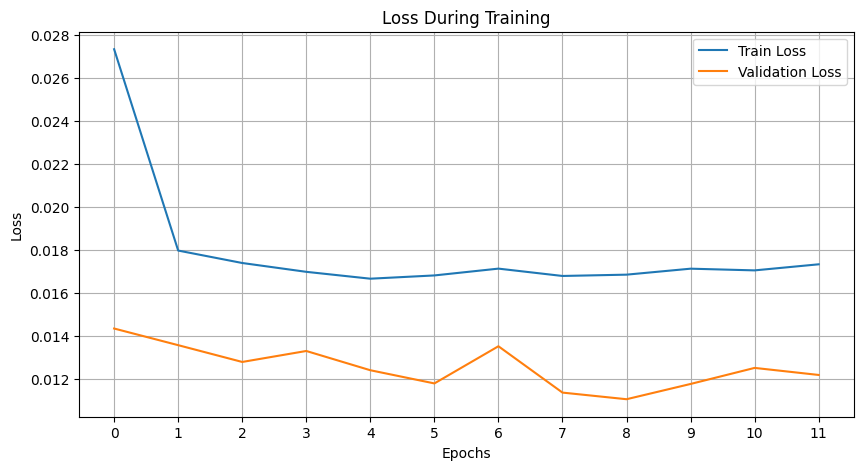

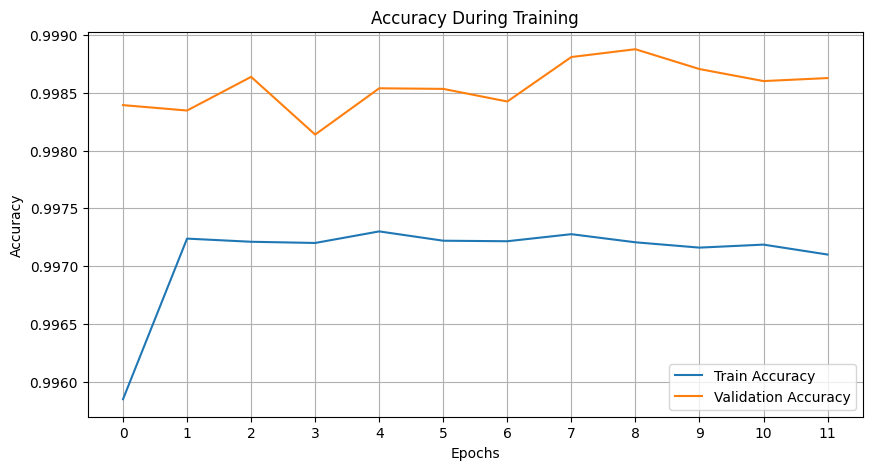

In [39]:
# Trainingsverlauf auslesen
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

# Verlust (Loss) plotten
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(len(train_loss)))
plt.show()

# Genauigkeit (Accuracy) plotten
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(range(len(train_accuracy)))
plt.show()

### Evaluierung des Modells auf dem Testdatensatz - Klassifikationsbericht und eine Konfusionsmatrix

In [40]:
# Vorhersagen auf dem Testdatensatz
y_pred_prob = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Klassifikationsbericht
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_classes)

6010/6010 ━━━━━━━━━━━━━━━━━━━━ 5s 750us/step
                              precision    recall  f1-score   support

                      BENIGN       1.00      1.00      1.00    158257
                 Botnet Ares       1.00      0.97      0.99        73
              DDoS-LOIC-HTTP       1.00      1.00      1.00      9515
               DoS GoldenEye       0.98      0.97      0.97       756
                    DoS Hulk       1.00      1.00      1.00     15847
               DoS Slowloris       0.97      0.94      0.95       386
Infiltration - NMAP Portscan       1.00      0.99      0.99      7177
              SSH-BruteForce       0.99      1.00      0.99       296

                    accuracy                           1.00    192307
                   macro avg       0.99      0.98      0.99    192307
                weighted avg       1.00      1.00      1.00    192307



Visualisierung der Konfusionsmatrix

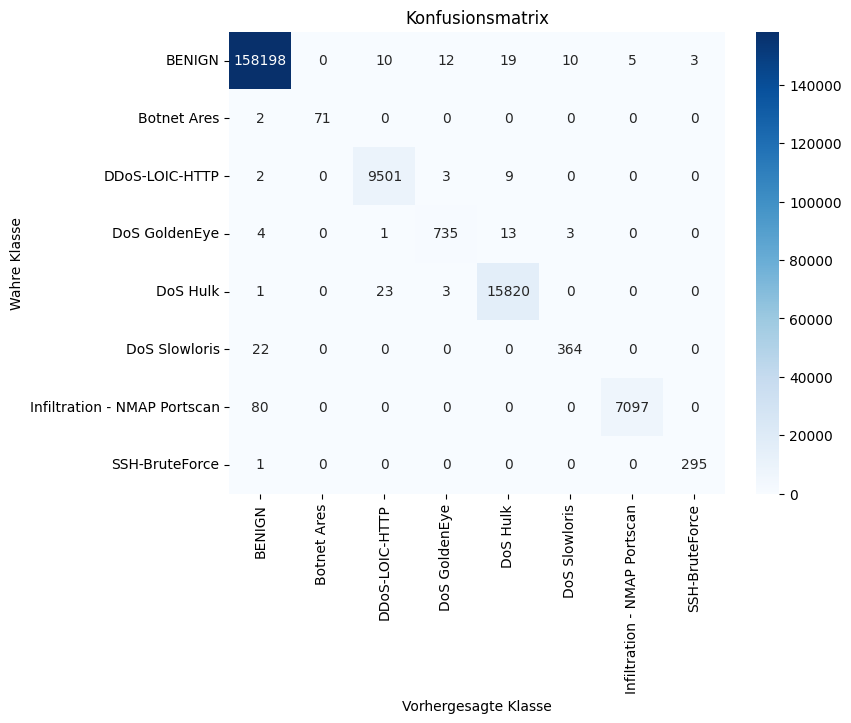

In [41]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()


### Speichern des Modells und der Vorverarbeitungsschritte

In [42]:
# Speichern des Modells
model.save('model.keras')

# Speichern des Label Encoders und Scalers
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']